In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from skimage import io as sio
from scipy import io
from pathlib import Path
from skimage.transform import resize
from keras.utils import to_categorical 

from PIL import Image

In [ ]:
%%bash

find ADNI/ -type f -exec mv -i '{}' ADNI/ ';'

## T1 Corrected Images

**Issues:**

* Same slice in different images corresponding to different locations
* Skull not stripped

In [2]:
data_dir = Path("../ADNI/ADNI/")
images = list(data_dir.glob("*.nii"))
len(images)

1400

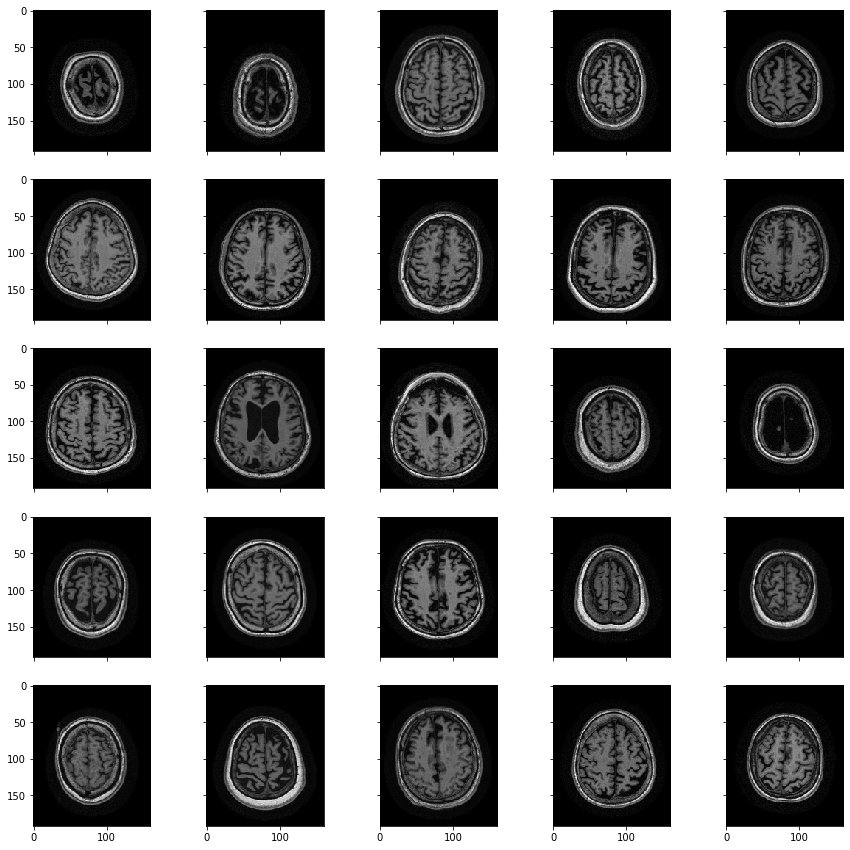

In [46]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j])
        image0 = Image.fromarray(image[:,:,50])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

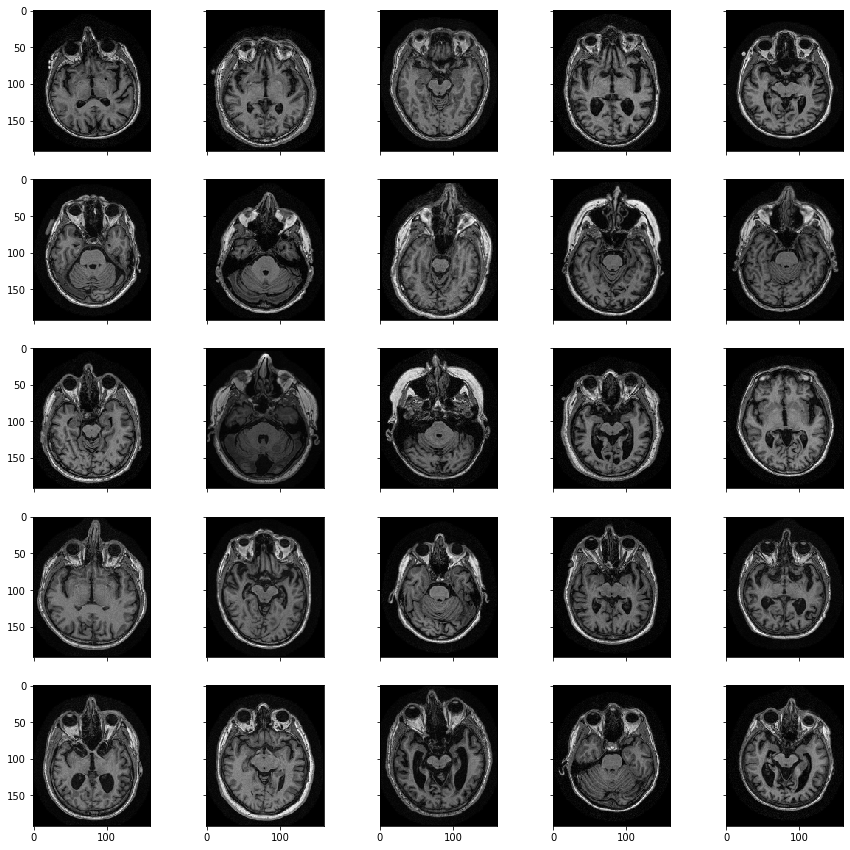

In [47]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j])
        image0 = Image.fromarray(image[:,:,100])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

## FSL Processed Images

### Visualizations

**Issues:**

* Still: Same slice in different images corresponding to different locations
* Some skulls not completely stripped

In [3]:
data_dir = Path("../ADNI/struc/")
images = list(data_dir.glob("*.nii"))
len(images)

1400

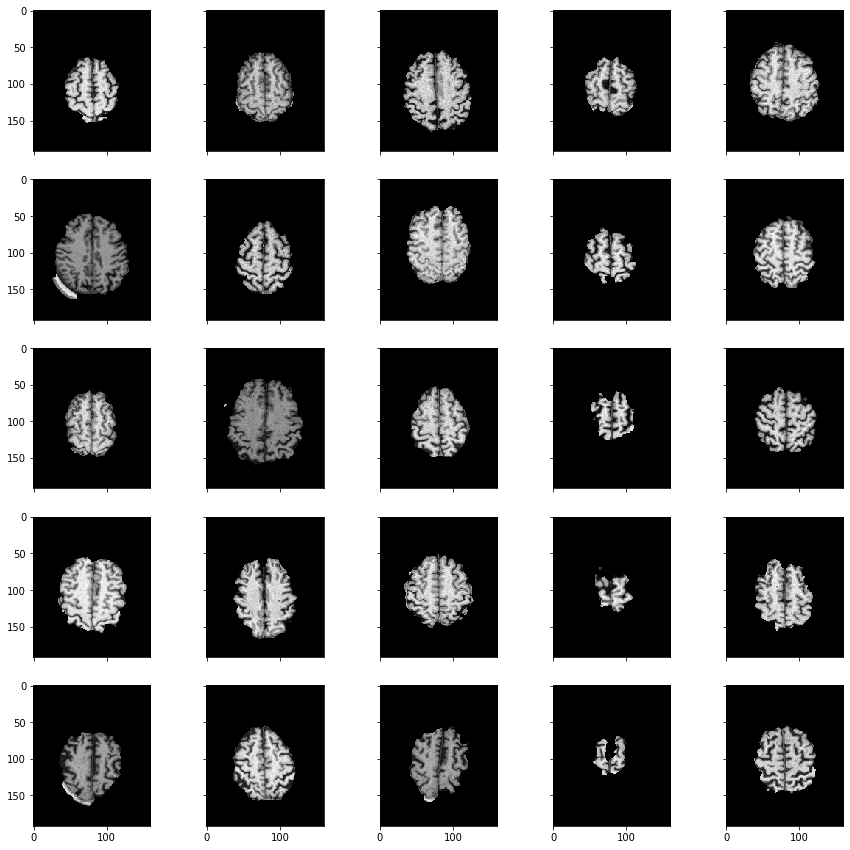

In [49]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j])
        image0 = Image.fromarray(image[:,:,50])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

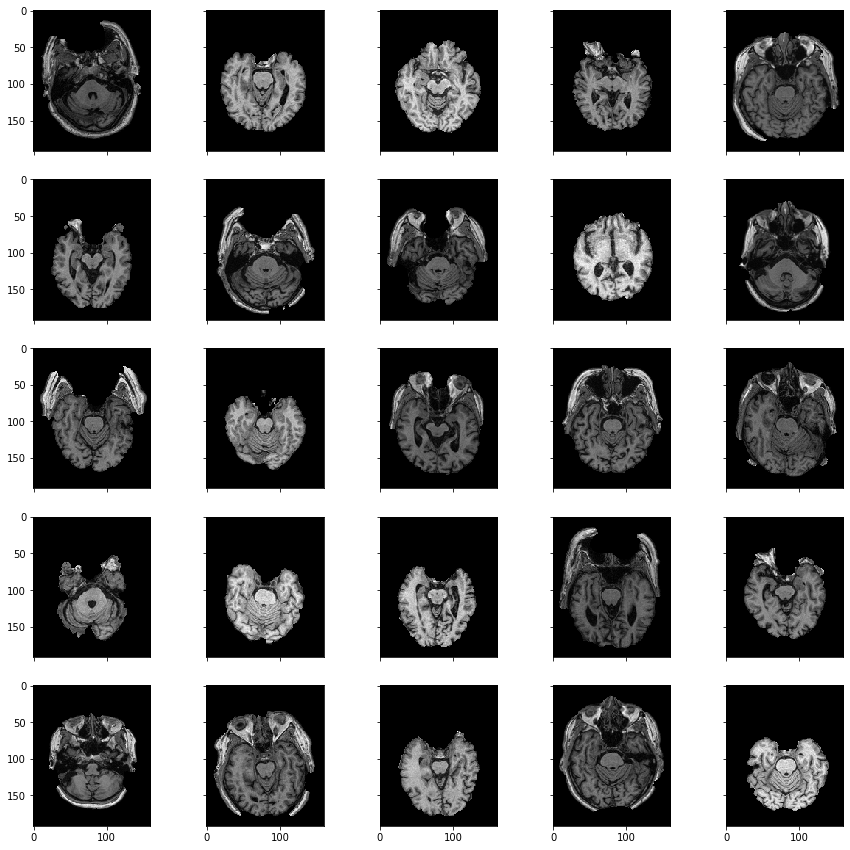

In [52]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j + 30])
        image0 = Image.fromarray(image[:,:,110])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

### Pairwise comparison

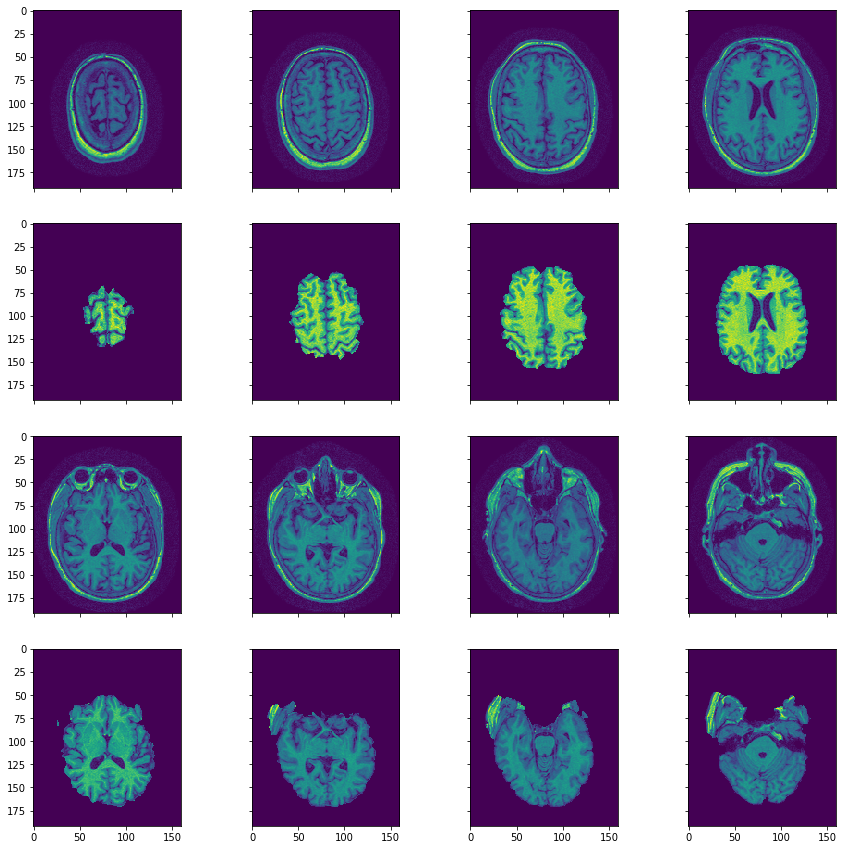

In [57]:
tmp = 'ADNI_003_S_1057_MR_MPR__GradWarp__B1_Correction__N3_Br_20080308121019979_S46176_I96201'
path_1 = '../ADNI/ADNI/' + tmp + '.nii'
path_2 = '../ADNI/struc/' + tmp + '_struc_brain.nii'

image_1 = sio.imread(path_1)
image_2 = sio.imread(path_2)

fig, ax = plt.subplots(4, 4, figsize=(15,15), sharex='col', sharey='row')
for i in [0,2]:
    for j in range(4):
        image1 = Image.fromarray(image_1[:,:,50+(i*2+j)*10])
        image2 = Image.fromarray(image_2[:,:,50+(i*2+j)*10])
        ax[i, j].imshow(np.transpose(image1))
        ax[i+1, j].imshow(np.transpose(image2))

## Match Labels

In [8]:
data_dir = Path("../ADNI/struc/")
images = list(data_dir.glob("*.nii"))
images.sort()

In [127]:
# create a data frame for every visit
pid  = []
date = []

for image in images:
    pid.append(str(image)[19:29])
    date.append(str(image)[69:77])
    
ADNI_info = pd.DataFrame({'pid':pid, 'date':pd.to_datetime(date, format="%Y%m%d")})
ADNI_info['Year'] = ADNI_info.date.apply(lambda x: x.year)

adni_merge = pd.read_csv("ADNIMERGE.csv", low_memory=False)
adni_merge = adni_merge[['PTID', 'DX', 'EXAMDATE']]
adni_merge['EXAMDATE'] = pd.to_datetime(adni_merge.EXAMDATE, format="%Y-%m-%d")
adni_merge['Year'] = adni_merge.EXAMDATE.apply(lambda x: x.year)

In [128]:
def returnDX(series):
    uni = series.unique()
    if 'Dementia' in uni:
        return 'Dementia'
    elif 'MCI' in uni:
        return 'MCI'
    elif 'CN' in uni:
        return 'CN'
    else:
        return np.nan

In [129]:
adni_DX = adni_merge.groupby(['PTID', 'Year']).agg({'DX': returnDX}).reset_index()
adni_DX = adni_DX.merge(adni_merge.groupby(['PTID']).agg({'DX': returnDX}).reset_index(),
                        how='left', left_on=['PTID'], right_on=['PTID'])
adni_DX['DX_x'] = adni_DX.DX_x.fillna(adni_DX['DX_y'])

ADNI_info = ADNI_info.merge(adni_DX, how='left', left_on=['pid', 'Year'], right_on=['PTID', 'Year'])

In [126]:
p_data = pd.read_csv("ADNI1_4_11_2020.csv")
p_data['date'] = pd.to_datetime(p_data['Acq Date'], format='%m/%d/%Y')
p_data = p_data.groupby(['Subject']).first().reset_index()[['Subject', 'Group']]
p_data.head()

Subject Group
0  002_S_0295    CN
1  002_S_0413    CN
2  002_S_0559    CN
3  002_S_0619    AD
4  002_S_0685    CN

In [132]:
ADNI_info = ADNI_info.merge(p_data, how='left', left_on=['pid'], right_on=['Subject'])
ADNI_info['DX_x'] = ADNI_info.DX_x.fillna(ADNI_info['Group'])
y = np.array(ADNI_info['DX_x'].map({'Dementia':'AD', 'MCI':'MCI', 'CN':'CN', 'AD':'AD'}))
np.unique(y, return_counts=True)

(array(['AD', 'CN', 'MCI'], dtype=object), array([451, 408, 541]))

In [214]:
ADNI_info.to_csv('ADNI_info.csv')

## Identify Starting Point for each Scan

### Method 1: Locate the first non-zero slice

In [175]:
def first_nonzero(image, n):
    """
    Function return the number of first non-zero slice
    """
    return np.sum(np.sum(np.sum(np.transpose(image[:,:,0:n]), axis=2), axis=1) == 0) 

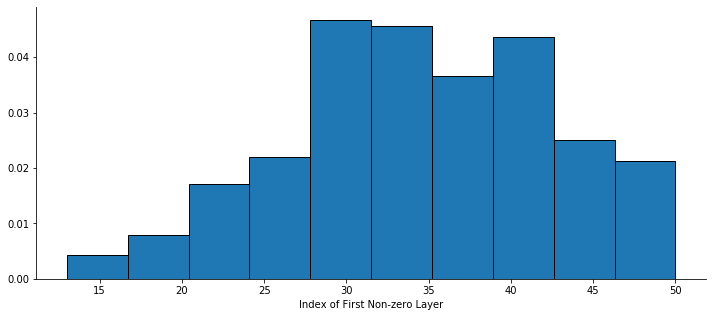

In [135]:
first = []
for image in images:
    tmp = sio.imread(image)
    first.append(first_nonzero(tmp, 50))
    
# initialize panel
f, ax = plt.subplots(figsize = (12,5))
# plot
ax.hist(first, density=True, edgecolor='black')
# disable top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# labels and title
ax.axes.set_xlabel("Index of First Non-zero Layer")
ax.axes.set_ylabel("");

**Now we see that each image shows approximately the same location for the same layer**

But still, not very ideal

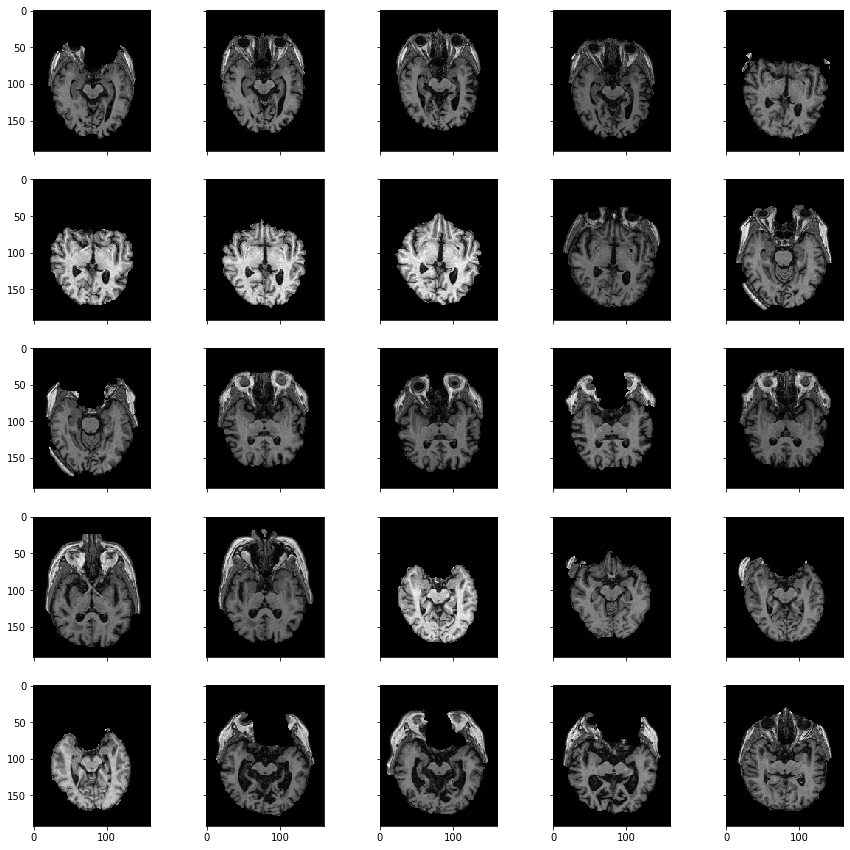

In [165]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j])
        image0 = Image.fromarray(image[:,:,first[i * 5 + j] + 60])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

### Method 2: Find a cutoff value for number of non-zero pixels in one layer

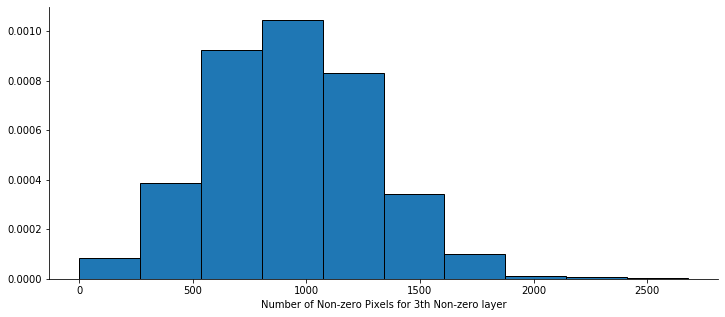

In [166]:
sum_3 = []
for i, image in enumerate(images):
    image = sio.imread(images[i])
    sum_3.append(len(np.nonzero(image[:,:,first[i] + 3])[0]))
    
# initialize panel
f, ax = plt.subplots(figsize = (12,5))
# plot
ax.hist(sum_3, density=True, edgecolor='black')
# disable top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# labels and title
ax.axes.set_xlabel("Number of Non-zero Pixels for 3th Non-zero layer")
ax.axes.set_ylabel("");

In [168]:
np.mean(sum_3)

933.9128571428571

In [169]:
np.std(sum_3)

354.818139905674

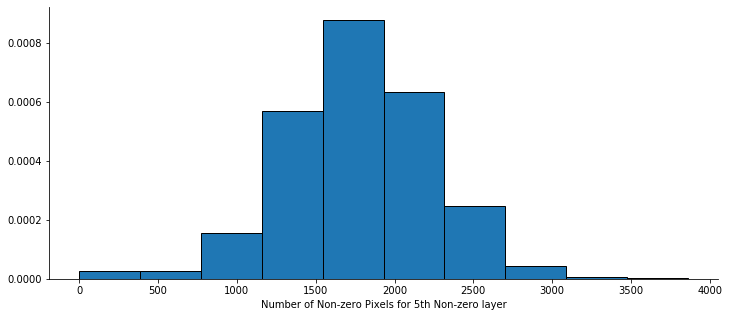

In [162]:
sum_5 = []
for i, image in enumerate(images):
    image = sio.imread(images[i])
    sum_5.append(len(np.nonzero(image[:,:,first[i] + 5])[0]))
    
# initialize panel
f, ax = plt.subplots(figsize = (12,5))
# plot
ax.hist(sum_5, density=True, edgecolor='black')
# disable top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# labels and title
ax.axes.set_xlabel("Number of Non-zero Pixels for 5th Non-zero layer")
ax.axes.set_ylabel("");

In [171]:
np.mean(sum_5)

1770.9921428571429

In [172]:
np.std(sum_5)

474.0044265266272

In [181]:
def nonzero_cut(image, first, cutoff):
    """
    Function return the number of first non-zero slice
    """
    n = image.shape[2]
    i = first
    while i < n:
        if len(np.nonzero(image[:,:,i])[0]) >= cutoff:
            return i
        if i > 100:
            raise Exception('Value not found')
        i += 1

In [183]:
cut_5 = []
for i, image in enumerate(images):
    image = sio.imread(images[i])
    cut_5.append(nonzero_cut(image, first[i], 1771))

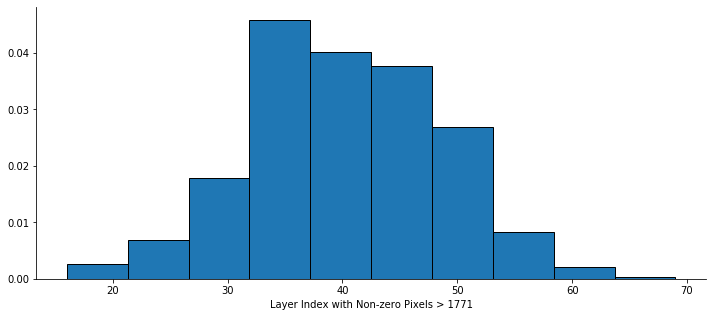

In [185]:
# initialize panel
f, ax = plt.subplots(figsize = (12,5))
# plot
ax.hist(cut_5, density=True, edgecolor='black')
# disable top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# labels and title
ax.axes.set_xlabel("Layer Index with Non-zero Pixels > 1771")
ax.axes.set_ylabel("");

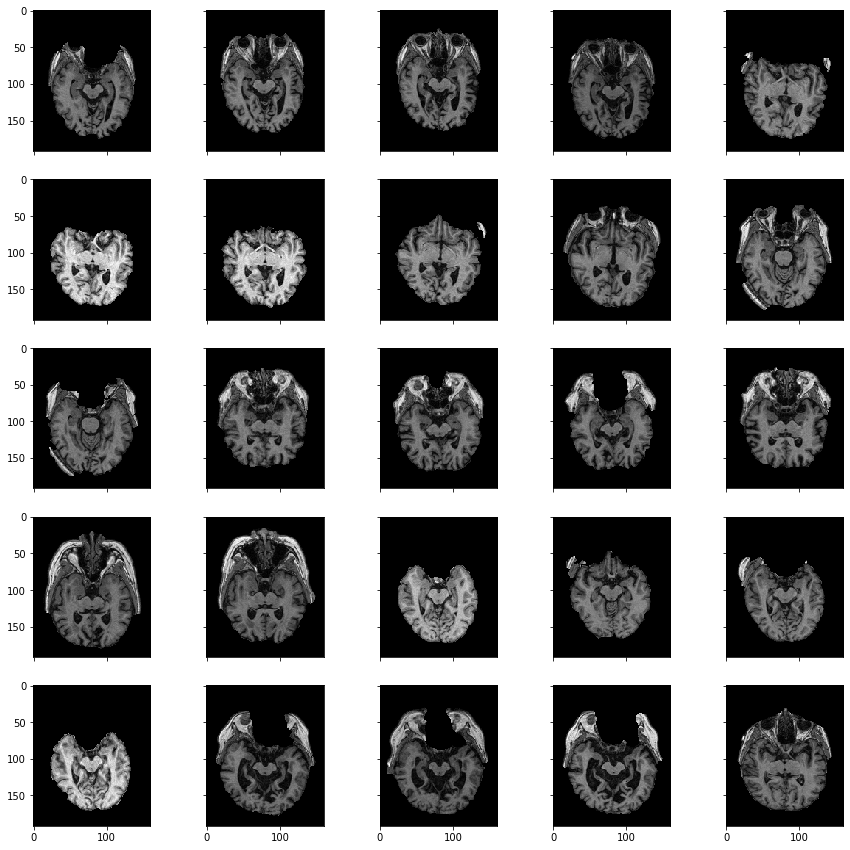

In [186]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j])
        image0 = Image.fromarray(image[:,:,cut_5[i * 5 + j] + 55])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

## Location of Hippocampus

### Visualizations

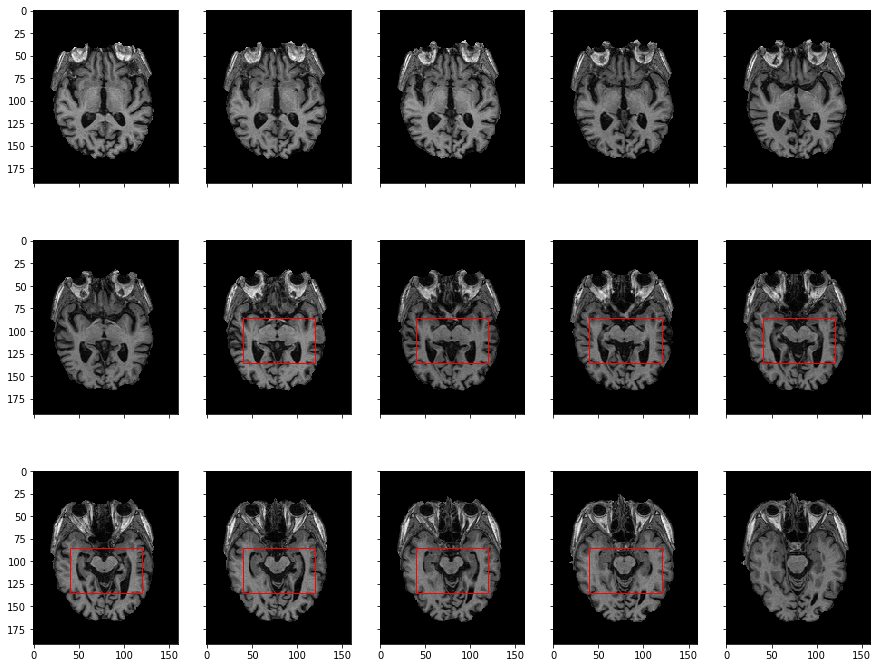

In [194]:
# CN
image = sio.imread(images[1])

fig, ax = plt.subplots(3, 5, figsize=(15,12), sharex='col', sharey='row')
for i in range(3):
    for j in range(5):
        ax[i,j].imshow(np.transpose(image[:,:,cut_5[1]+45+i*5+j]),cmap = plt.get_cmap('gray'))
        if i*5+j > 5 and i*5+j < 14:
            rect = patches.Rectangle((40,85), 80, 50,linewidth=1, edgecolor='r', facecolor='none')
            ax[i,j].add_patch(rect)

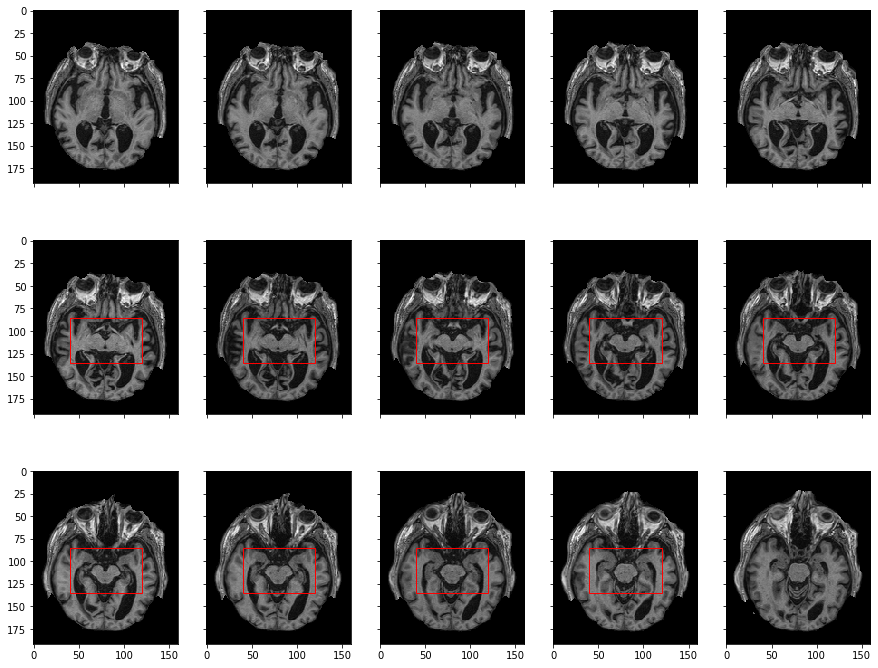

In [205]:
# AD
image = sio.imread(images[75])

fig, ax = plt.subplots(3, 5, figsize=(15,12), sharex='col', sharey='row')
for i in range(3):
    for j in range(5):
        ax[i,j].imshow(np.transpose(image[:,:,cut_5[75]+55+i*5+j]),cmap = plt.get_cmap('gray'))
        if i*5+j > 4 and i*5+j < 14:
            rect = patches.Rectangle((40,85), 80, 50,linewidth=1, edgecolor='r', facecolor='none')
            ax[i,j].add_patch(rect)

Hippocampus: (`cut_5` + 45) - (`cut_5` + 75)

Length 30:130, Width 70:170\n

Shape: 100 * 100 * 30

### Final Patch

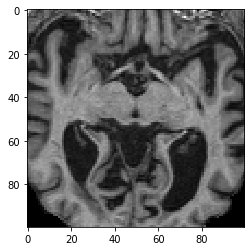

In [213]:
plt.imshow(np.transpose(image[30:130,70:170,cut_5[75]+60]),cmap = plt.get_cmap('gray'));

In [215]:
X = []
for i, image in enumerate(images):
    tmp = sio.imread(image)
    X.append(tmp[30:130, 70:170, (cut_5[i]+45):(cut_5[i]+75)])
X = np.array(X)

y = np.array(ADNI_info['DX_x'].map({'Dementia':2, 'AD':2, 'MCI':1, 'CN':0}))
y = to_categorical(y).astype(np.integer)

In [224]:
io.savemat("ADNI_new.mat", {'y' : y, 'X' : X, 'first': np.array(cut_5)})